In [1]:
import os
import uuid
from typing import TypedDict, Optional
from typing_extensions import NotRequired
from langgraph.graph import StateGraph,START,END
from langgraph.checkpoint.memory import InMemorySaver
from langchain.chat_models import init_chat_model

/Users/sulbhajain/Documents/Personal/genAI_projects/langgraph_agents/lang_env/lib/python3.14/site-packages/langchain_core/_api/deprecation.py:26: UserWarning: Core Pydantic V1 functionality isn't compatible with Python 3.14 or greater.
  from pydantic.v1.fields import FieldInfo as FieldInfoV1


In [2]:
# load .env file
from dotenv import load_dotenv
load_dotenv()

True

In [ ]:
class AgentMemory:
    """Class to handle agent memory storage and retrieval."""
    def __init__(self):
        self.short_memory = {}
        self.working_memory = InMemorySaver()
        self.long_memory = VectorDBMemory()


    def save(self, key: str, value: str):
        self.short_memory[key] = value

    def retrieve(self, key: str) -> Optional[str]:
        return self.short_memory.get(key, None)

In [7]:
# -------------------------------------------------------------------
# 2. LLM initialization (agent's "brain")
# -------------------------------------------------------------------
#
# NOTE: Replace model name with any supported Anthropic model you actually have
# The docs use "claude-sonnet-4-5-20250929" as an example. :contentReference[oai
model = init_chat_model(
                        "claude-3-7-sonnet-20250219",  
                        # or another available claude-* model
                        temperature=0,
                        api_key=os.getenv("ANTHROPIC_API_KEY")
                        )

In [11]:
# -------------------------------------------------------------------
# 1. State definition (this is the "memory" of our agent)
# -------------------------------------------------------------------
class AgentState(TypedDict):
    """
    State carried through the graph.
    - user_goal: what the user wants
    - plan: high-level plan the agent came up with
    - answer: final answer generated from the plan
    """
    user_goal: str
    plan: NotRequired[str]
    answer: NotRequired[str]


# -------------------------------------------------------------------
# 3. Nodes in our agentic workflow
# Node 1: PLAN
# Node 2: EXECUTE / ANSWER
# -------------------------------------------------------------------
def plan_node(state: AgentState) -> dict:
    """Use the LLM to come up with a short plan for the user's goal."""
    goal = state["user_goal"]
    msg = model.invoke(
        f"You are a helpful assistant. The user goal is:\n\n"
        f'"{goal}".\n\n'
        f"Create a concise 3-step plan to achieve this goal."
    )
    return {"plan": msg.content}


def answer_node(state: AgentState) -> dict:
    """Use the plan + goal to produce a full answer."""
    goal = state["user_goal"]
    plan = state["plan"]
    msg = model.invoke(
        f"The user goal is:\n\n{goal}\n\n"
        f"Here is the high-level plan you created earlier:\n\n{plan}\n\n"
        f"Now write a detailed, actionable answer for the user. "
        f"Keep it within 3 paragraphs."
    )
    return {"answer": msg.content}


# -------------------------------------------------------------------
# 4. Build and compile the LangGraph workflow with a checkpointer
# -------------------------------------------------------------------
def build_graph():
    workflow = StateGraph(AgentState)
    
    # Add nodes
    workflow.add_node("plan", plan_node)
    workflow.add_node("answer", answer_node)

    # Wire up edges: START -> plan -> answer -> END
    workflow.add_edge(START, "plan")
    workflow.add_edge("plan", "answer")
    workflow.add_edge("answer", END)
    
    # Add an in-memory checkpointer (for dev; use durable in prod)
    checkpointer = InMemorySaver()
    graph = workflow.compile(checkpointer=checkpointer)
    return graph


# -------------------------------------------------------------------
# 5. Helper functions to run once, inspect history, and time travel
# -------------------------------------------------------------------
def run_initial(graph):
    """
    Run the graph once with an initial user goal.
    Returns:
    graph, config (with thread_id), final_state
    """
    # Each logical conversation/run gets a thread_id
    thread_id = str(uuid.uuid4())
    config = {
        "configurable": {
            "thread_id": thread_id,
        }
    }
    initial_input: AgentState = {
        "user_goal": "I want to get fit in 3 months with minimal equipment."
    }
    
    print("=== Initial run ===")
    final_state = graph.invoke(initial_input, config)
    
    print("\n[PLAN]")
    print(final_state["plan"])
    print("\n[ANSWER]")
    print(final_state["answer"])
    print(f"\nThread ID: {thread_id}")
    print("=" * 60)
    
    return config, final_state


def show_history(graph, config):
    """
    Print the checkpoint history for the given thread.
    """
    print("\n=== Checkpoint history (most recent first) ===")
    states = list(graph.get_state_history(config))
    
    for i, snapshot in enumerate(states):
        checkpoint_id = snapshot.config["configurable"]["checkpoint_id"]
        print(f"Index: {i}")
        print(f"  next nodes: {snapshot.next}")
        print(f"  checkpoint_id: {checkpoint_id}")
        print(f"  values: {snapshot.values}")
        print("-" * 40)
    
    return states


def time_travel_and_modify_plan(graph, states):
    """Example of time travel:
    1. Choose the checkpoint just before `answer` node.
    2. Modify the `plan` in that checkpoint.
    3. Resume execution from that checkpoint to get a new answer.
    """
    # states are in reverse chronological order (most recent first)
    # In our simple graph:
    # - Last state: after END
    # - One before: after `answer`
    # - One before that: after `plan`
    #
    # We want to branch from the checkpoint that already has a `plan`
    # but has not yet produced `answer` -> that is the state after `plan`.
    # Find a snapshot whose `next` contains 'answer'
    selected_state = None
    for snapshot in states:
        if "answer" in snapshot.next:
            selected_state = snapshot
            break
    
    if selected_state is None:
        raise RuntimeError(
            "Could not find checkpoint before 'answer' node"
        )

    print("\n=== Selected checkpoint (before 'answer' node) ===")
    print(f"next nodes: {selected_state.next}")
    print(f"values: {selected_state.values}")
    print(f"original plan:\n{selected_state.values.get('plan')}")
    print("-" * 60)

    # New plan we want to test (this is your "what-if" branch)
    new_plan = (
        "1. Focus on progressive overload bodyweight exercises (pushups, squats)\n"
        "2. Add 3x/week brisk walking or light jogging.\n"
        "3. Track nutrition with a mild calorie deficit and sufficient protein."
    )
    
    # update_state creates a NEW checkpoint for the same thread with a new check
    new_config = graph.update_state(
        selected_state.config,
        values={"plan": new_plan},
    )
    
    print("\n=== New config after update_state ===")
    print(new_config)
    print("-" * 60)

    # Now resume the graph from that checkpoint.
    # IMPORTANT: we pass input=None to say "continue from saved state"
    print("\n=== Resuming from modified checkpoint (time travel) ===")
    new_final_state = graph.invoke(None, new_config)
    
    print("\n[MODIFIED PLAN]")
    print(new_final_state["plan"])
    print("\n[NEW ANSWER]")
    print(new_final_state["answer"])
    print("=" * 60)
    
    return new_final_state

In [ ]:
def main():
    graph = build_graph()
    # 1) Run once
    config, _final_state = run_initial(graph)
    # 2) Inspect history and choose checkpoint
    states = show_history(graph, config)
    # 3) Time travel: modify plan at a past checkpoint and resume
    new_state = time_travel_and_modify_plan(graph, states)

    return new_state

In [ ]:
new_state = main()

=== Initial run ===

[PLAN]
# 3-Month Fitness Plan with Minimal Equipment

1. **Start with bodyweight training** 3-4 times weekly: push-ups, squats, lunges, planks, and burpees. Begin with 3 sets of 8-12 reps, gradually increasing intensity as you progress.

2. **Add cardio workouts** 2-3 times weekly: jogging, brisk walking, jumping rope, or HIIT sessions (30-45 minutes). Alternate between steady-state cardio and interval training.

3. **Maintain proper nutrition and recovery**: Focus on whole foods, adequate protein (0.8g per pound of bodyweight), and staying hydrated. Ensure 7-8 hours of sleep and include 1-2 rest days weekly to allow muscle recovery.

[ANSWER]
# Your 3-Month Minimal Equipment Fitness Plan

Start with a foundation of bodyweight training 3-4 times weekly, focusing on compound movements that work multiple muscle groups simultaneously. Perform push-ups, squats, lunges, planks, and burpees in circuit format (3 sets of 8-12 reps with 60-second rest between sets). As thes

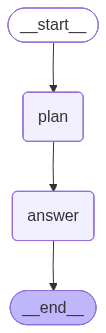

In [14]:
from IPython.display import Image

graph = build_graph()
Image(graph.get_graph().draw_mermaid_png())

# Example Scenarios

LangGraph time travel is particularly useful in scenarios such as:

## Conversational Agents
Imagine a chatbot that generates content and then posts it publicly. You might want to rewind to before the final post, tweak the generated text, and replay to see alternate outcomes. For instance, one tutorial describes using time travel to "jump into the past and resume your workflow from any previous checkpoint," enabling you to rerun a joke-generation example with a modified prompt.

In customer support, you could rewind a dialogue to modify a misunderstood user input and continue.

## Debugging Complex Workflows
In multi-step workflows (e.g., data pipelines or decision trees), if something goes wrong mid-way, you can resume after fixing the state without re-running costly earlier steps. LangGraph's persistence means a crash or bug only requires you to rewind to the problematic step and re-run from there.

## What-if Analysis
In planning or decision-making agents, you can explore different branches of logic by forking at decision points. For example, in a planning graph one branch might take one action, another branch a different action; time travel lets you easily spin up both runs from the same prior state.

## Human-in-the-Loop and Auditing
When human approval is required at some step (e.g., approving a generated document), time travel allows you to store the checkpoint at the approval point, let the human review it, and then either accept or modify it. If rejected, you can resume from before the change with new input. Also, auditors can replay the conversation history to see exactly how decisions were made.

## Iterative Refinement (Reflection/Reflexion)
In agents that refine their answers iteratively (self-critique loops), time travel can help visualize each iteration's state or adjust an intermediate answer and rerun subsequent steps.

## Summary
In all these cases, LangGraph's time travel is **critical** because it saves developer effort and adds robustness: you don't have to start workflows from scratch every time you tweak something. Checkpointing lets you save an agent in a specific state and time travel lets you replay conversations from those states, which helps to debug errors or replay and test different conversation paths.